In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# just set the seed for the random number generator
np.random.seed(107)

plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
cryptos = pd.read_csv("data/crypto_1y.csv", parse_dates=True, index_col="time")
cryptos.head()

,BTC,ETH,SOL,XRP,BNB,USDT,ADA,DOT,LUNA,DOGE
time,,,,,,,,,,
2020-11-01 01:00:00,13770.78,389.16,1.556,0.2403,28.59,1.002,0.09378,4.194,0.3030,0.002549
2020-11-01 02:00:00,13721.73,387.91,1.553,0.2393,28.39,1.002,0.09374,4.193,0.3011,0.002570
2020-11-01 03:00:00,13700.10,386.75,1.534,0.2392,28.40,1.002,0.09355,4.177,0.3013,0.002574
2020-11-01 04:00:00,13683.91,386.57,1.529,0.2391,28.23,1.002,0.09338,4.157,0.3002,0.002567
2020-11-01 05:00:00,13705.51,386.08,1.531,0.2391,28.27,1.002,0.09315,4.143,0.3006,0.002611


In [16]:
def calculateReturn(df, coin: str):
    df.loc[:, "price"] = df.loc[:, coin]
    df.loc[:, "logPrice"] = np.log(df.loc[:, "price"])
    df.loc[:, "return"] = df.loc[:, "logPrice"] - df.loc[:, "logPrice"].shift(1)
    
    df.loc[df.index[0], "return"] = 0
    df.loc[df.index[0], 'signal'] = 0
    cols = ['price', 'logPrice', 'return', 'signal']
    return df.loc[:, cols]


def detectEWMABuySignal(df, start, feature, mu, sigma, lambdaa=0.3, L=3):
    df.loc[df.index[start],'z']=lambdaa*df.loc[df.index[start], feature] + (1-lambdaa)*mu
    df.loc[df.index[start],'ucl']=mu+(L*sigma*np.sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*1))))
    df.loc[df.index[start],'lcl']=mu-(L*sigma*np.sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*1))))
    
    for i in range(start+1, len(df)):
        
        z = lambdaa*df.loc[df.index[i], feature] +(1-lambdaa)*df.loc[df.index[i-1],'z']
        ucl = mu+(L*sigma*np.sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*(i-start+1)))))
        lcl = mu-(L*sigma*np.sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*(i-start+1)))))
        df.loc[df.index[i], 'z'] = z
        df.loc[df.index[i],'ucl']= ucl
        df.loc[df.index[i],'lcl']= lcl
    
        if z >= ucl:
            # buy
            df.loc[df.index[i], 'signal'] = 1
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'equity'] * (1-transactionFee)
            df.loc[df.index[i], 'share'] = df.loc[df.index[i], 'equity'] / df.loc[df.index[i], 'price']
            return detectEWMASellSignal(df, i+1, feature=feature, mu=mu, sigma=sigma)
        elif z <= lcl:
            # reset EWMA and hold
            df.loc[df.index[i], 'signal'] = 0
            df.loc[df.index[i], 'share'] = df.loc[df.index[i-1], 'share']
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'equity']
            return detectEWMABuySignal(df, i+1, feature=feature, mu=mu, sigma=sigma)
        else:
            #hold
            df.loc[df.index[i], 'signal'] = 0
            df.loc[df.index[i], 'share'] = df.loc[df.index[i-1], 'share']
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'equity']

    return df


def detectEWMASellSignal(df, start, feature, mu, sigma, lambdaa=0.3, L=3):
    df.loc[df.index[start],'z']=lambdaa*df.loc[df.index[start], feature] + (1-lambdaa)*mu
    df.loc[df.index[start],'ucl']=mu+(L*sigma*np.sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*1))))
    df.loc[df.index[start],'lcl']=mu-(L*sigma*np.sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*1))))
    
    for i in range(start+1, len(df)):
        
        z = lambdaa*df.loc[df.index[i], feature] +(1-lambdaa)*df.loc[df.index[i-1],'z']
        ucl = mu+(L*sigma*np.sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*(i-start+1)))))
        lcl = mu-(L*sigma*np.sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*(i-start+1)))))
        df.loc[df.index[i], 'z'] = z
        df.loc[df.index[i],'ucl']= ucl
        df.loc[df.index[i],'lcl']= lcl
    
        if z <= lcl:
            # sell
            df.loc[df.index[i], 'signal'] = -1
            df.loc[df.index[i], 'share'] = 0
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'share'] *  df.loc[df.index[i], 'price']
            return detectEWMABuySignal(df, i+1, feature=feature, mu=mu, sigma=sigma)
        elif z >= ucl:
            # reset EWMA and hold
            df.loc[df.index[i], 'signal'] = 0
            df.loc[df.index[i], 'share'] = df.loc[df.index[i-1], 'share']
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i], 'share'] * df.loc[df.index[i], 'price']
            return detectEWMASellSignal(df, i+1, feature=feature, mu=mu, sigma=sigma)
        else:
            #hold
            df.loc[df.index[i], 'signal'] = 0
            df.loc[df.index[i], 'share'] = df.loc[df.index[i-1], 'share']
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i], 'share'] * df.loc[df.index[i], 'price']

    return df


def createEWMATradeSignal(df, feature='return'):
    df.loc[df.index[0], 'equity'] = 100
    df.loc[df.index[0], 'share'] = 0
    mu = np.mean(df.loc[:, feature])
    sigma = np.std(df.loc[:, feature])
    return detectEWMABuySignal(df, start=0, feature=feature, mu=mu, sigma=sigma)

In [17]:
df = (cryptos
      .pipe(calculateReturn, "BTC")
      .pipe(createEWMATradeSignal))

In [18]:
df

,price,logPrice,return,signal,z,ucl,lcl
time,,,,,,,
2020-11-01 01:00:00,13770.78,9.530304,0.000000,0.0,0.000120,0.008582,-0.008240
2020-11-01 02:00:00,13721.73,9.526736,-0.003568,0.0,-0.000987,0.010438,-0.010096
2020-11-01 03:00:00,13700.10,9.525158,-0.001578,0.0,-0.001164,0.011234,-0.010892
2020-11-01 04:00:00,13683.91,9.523976,-0.001182,0.0,-0.001169,0.011604,-0.011262
2020-11-01 05:00:00,13705.51,9.525553,0.001577,0.0,-0.000345,0.011781,-0.011439
...,...,...,...,...,...,...,...
2021-10-31 20:00:00,60969.55,11.018130,0.003807,0.0,0.001409,0.011949,-0.011606
2021-10-31 21:00:00,61483.09,11.026517,0.008388,0.0,0.003502,0.011949,-0.011606
2021-10-31 22:00:00,61417.06,11.025443,-0.001075,0.0,0.002129,0.011949,-0.011606


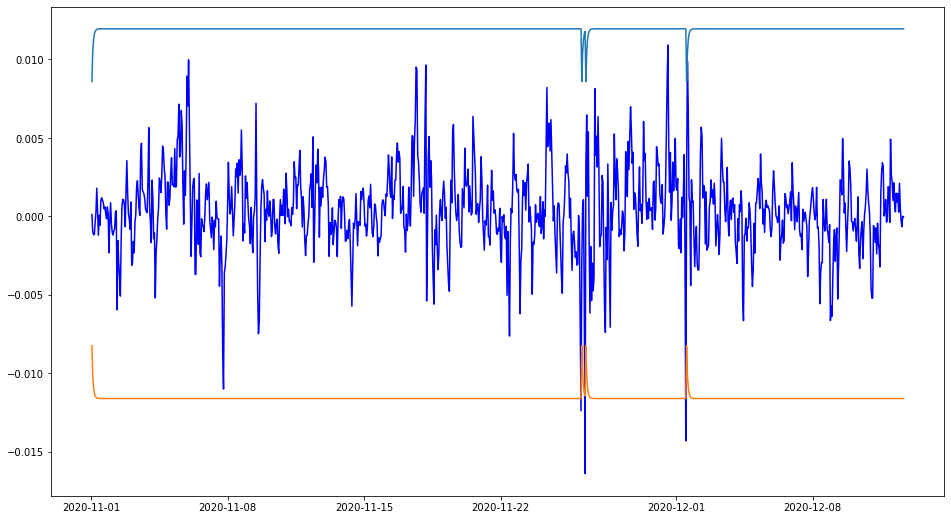

In [19]:
pdf = df.head(1000)
plt.plot(pdf.index, pdf.z, c='b')
plt.plot(pdf.index, pdf.ucl)
plt.plot(pdf.index, pdf.lcl)

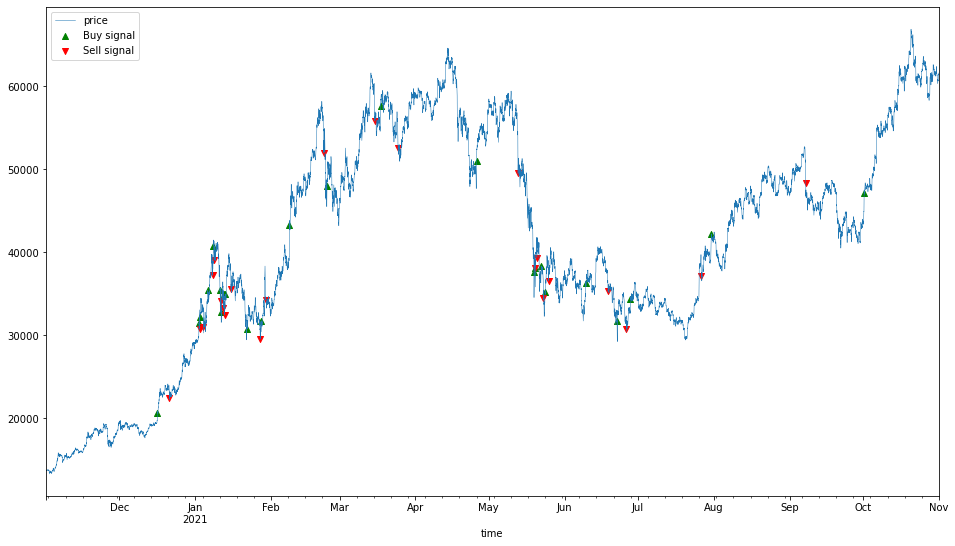

In [25]:
def plotPriceWithSignal(df):
    # optimze looking later
    df.loc[:, 'price'].plot(linewidth=.5)
    buy = df.loc[df['signal']==1, 'price']
    plt.scatter(buy.index, buy, c="g", marker="^", label="Buy signal")
    sell = df.loc[df['signal']==-1, 'price']
    plt.scatter(sell.index, sell, c="r", marker="v", label="Sell signal")
    plt.legend(loc='best')
    plt.show()
    
plotPriceWithSignal(df)

In [5]:
from statistics import mean

lambdaa=0.3
L=3
mu0=[]
sigma=[]
for i in range(0,10):
    mu0.append(mean(cryptos[cryptos.columns[i]]))
    sigma.append(np.std(cryptos[cryptos.columns[i]]))

print(mu0, 3*'\n', sigma)

[41413.839783105024, 2155.8729566210045, 46.135786757990864, 0.7715060616438356, 286.4517694063927, 1.0005213812785387, 1.2505096506849316, 23.783749543378995, 13.5102749543379, 0.1695694062785388] 


 [13371.982212568415, 1060.9252195796873, 55.823928453616375, 0.37935471619823125, 183.54518163166927, 0.0012801097487254644, 0.7816715372233145, 12.459006274828736, 13.226018213432871, 0.1456918199304615]


In [6]:
new_z = [lambdaa*cryptos['BTC'].values[0]+(1-lambdaa)*mu0[0]]
for j,k in zip(range(len(cryptos.BTC)), cryptos.BTC[1:len(cryptos['BTC']+1)]):
    new_z.append(lambdaa*k+(1-lambdaa)*new_z[j-1])

In [7]:
from math import sqrt

ucl = []
lcl = []
cl = []
for i in range(1,len(cryptos.BTC)+1):
    ucl.append(mu0[0]+(L*sigma[0]*sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*i)))))
    lcl.append(mu0[0]-(L*sigma[0]*sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*i)))))

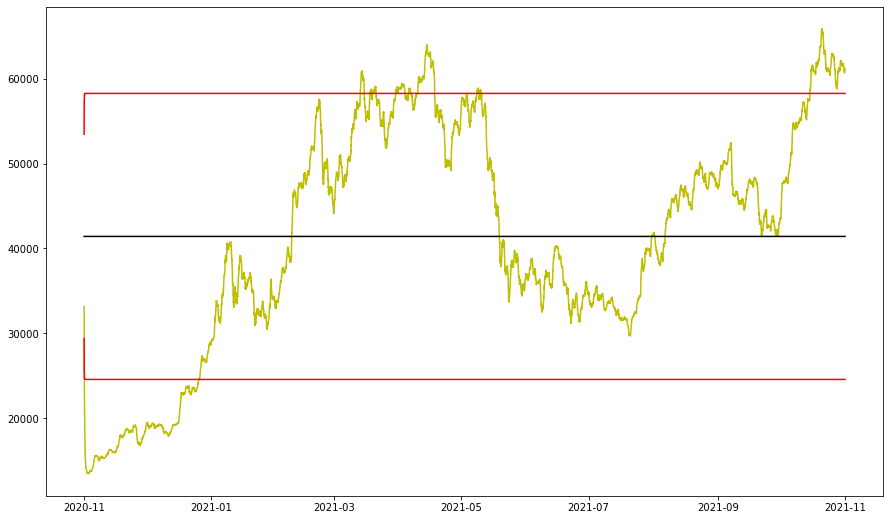

In [8]:
plt.figure(figsize=(15,9))
#plt.plot(cryptos.index,cryptos.BTC,c='b')
plt.plot(cryptos.index,new_z, color='y')
plt.plot(cryptos.index,np.array([mu0[0]]*len(cryptos.BTC)), color='black')
plt.step(cryptos.index,ucl,c='r',)
plt.step(cryptos.index,lcl,c='r',)
#plt.step(data.i,data.UCL_ewma, where='post', color='r', marker='h', markersize=4)
#plt.step(data.i,data.LCL_ewma, where='post', color='r', marker='h', markersize=4)
#plt.title("EWMA Conrol Chart", fontsize=20, fontname="Times New Roman")
plt.show()

In [ ]:
new_z = [lambdaa*cryptos['BTC'].values[0]+(1-lambdaa)*mu0[0]]
for j,k in zip(range(len(cryptos.BTC)), cryptos.BTC[1:len(cryptos['BTC']+1)]):
    new_z.append(lambdaa*k+(1-lambdaa)*new_z[j-1])

In [ ]:
len(cryptos) # 0 ta 8759

In [ ]:
a = [1, 2, 3, 4, 5, 6, 7]
list(range(1, len(a)))

In [58]:
len(a)

7

In [62]:
Z1[0]

33120.921848173515

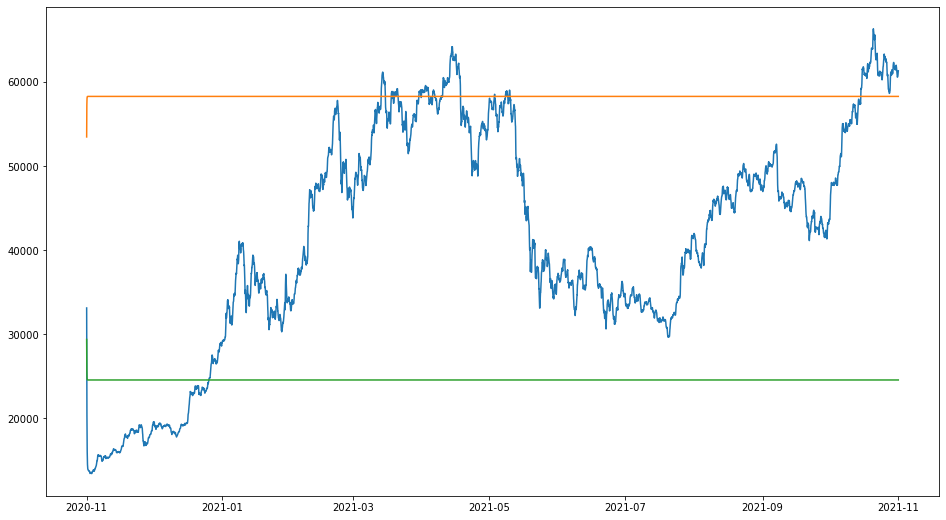

In [70]:
#dor
Z1=[lambdaa*cryptos['BTC'].values[0]+(1-lambdaa)*mu0[0]]
ucl = [mu0[0]+(L*sigma[0]*sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*1))))]
lcl = [mu0[0]-(L*sigma[0]*sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*1))))]
for j,k in zip(range(1, len(cryptos)+1), cryptos.BTC[1:len(cryptos['BTC'])+1]):
    Z1.append(lambdaa*k+(1-lambdaa)*Z1[j-1])
    ucl.append(mu0[0]+(L*sigma[0]*sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*(j+1))))))
    lcl.append(mu0[0]-(L*sigma[0]*sqrt(lambdaa/((2-lambdaa)*1)*(1-(1-lambdaa)**(2*(j+1))))))
plt.plot(cryptos.index,Z1)
plt.plot(cryptos.index,ucl)
plt.plot(cryptos.index,lcl)